# **Malaria Detection**

##<b>Problem Definition</b>
**The context:**

Malaria is caused by the transmission of the plasmodium protozoa to red blood cells (RBCs) via mosquito bites. The result is infection of the oxygen-carrying RBCs and respiratory complications. In 2020, there were 241 million diagnosed episodes with 627,000 fatalities. Although the mortality is less than 1%, two-thirds are children under the age of 5. The direct cost of treatment, prevention, and premature death has been estimated to be $12 billion; the indirect costs to economic growth and to the social fabric of affected communities is much larger.

There are several issues to properly diagnosing plasmodium infection. Most of the 50% of the world population at risk of infection live in poorer countries of Africa and southeast Asia where there are a number of other endemic respiratory diseases. These diseases make it all the more difficult to get a correct diagnosis which is critical for appropriate treatment. To date, the most reliable and accurate method to diagnose infection and identifying which of the plasmodium strains is responsible has been microscopic analysis of stained blood samples. Other methods have significant drawbacks including cost and reagent stability. In the hands of a skilled microscopist, diagnosis is 98% accurate.

In recent years, machine learning has been used to address the problem of accurate diagnoses in a variety of fields of human health, including malarial disease. Although progress has been made, human diagnostic accuracy has yet to be met.

**The objectives:**

The ultimate goal is to provide tools to local health practitioners in order to rapidly and accurately diagnose malaria at the time of patient evaluation.

**The key questions:**

Can deep learning models match or exceed the diagnostic accuracy of skilled microscopists?<br>
Can images provided by local health professionals be used to get accurate diagnoses?


**The problem formulation:**

1) Is the dataset used here of sufficient quality to teach a model?
  Is the dataset large enough? Is it balanced? Are the images of high enough quality? <br>
2) What data processing will be required?
  The images will all need to be resized to uniform dimensions. How small an image size can we use?
  Do we need to sharpen, de-noise, or otherwise manipulate the images? <br>
3) What image content features are important? The stained plasmodium within the cell? The cell size and shape?<br>
4) How many images per patient are required to minimize any false diagnoses?<br>
5) Which accuracy measures should be utilized?<br>


## <b>Data Description </b>

The original data is found on the NIH website:  https://ceb.nlm.nih.gov/repositories/malaria-datasets/

There are a total of 24,958 train and 2,600 test images (colored) that were taken from microscopic images. These images are of the following categories:

**Parasitized**: The parasitized cells contain the Plasmodium parasite which causes malaria
**Uninfected**: The uninfected cells are free of the Plasmodium parasites

A version of the dataset segregated by category into 2 folders can be found on Kaggle: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria


### <b>Loading libraries</b>

In [ ]:
# data
import numpy as np
import pandas as pd

# graphing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# image
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import urllib.request

# file / path handling
import os
from zipfile import ZipFile
from numpy import save

import warnings
warnings.filterwarnings("ignore")

### <b>Load the data</b>

The dataset used here is from the Applied Data Science course (MIT Professional Education). It has been split into training and test sets as well as uninfected and parasitized.<br>
For this exercise, the dataset is presumed have been loaded into the parent_dir with the fake path: 'path_to_main_folder'


The extracted folder has folders for train and test data each containing subfolders for parasitized and uninfected cells.

The individual images need to be collated into arrays for either training or testing and then separated into image arrays and diagnosis arrays.

The images are of very different sizes as they were cropped as individual cells from images of blood smears.<br>

The images need to be of a uniform  size for the training. As we plan to use the VGG16 pretrained model, we will resize the images to be consistent with that model: 224 x 224 pixels^2.

As it is unknown if any physical cellular features are important, the aspect ratio of the images will be kept constant: the longest dimension of the image will be brought to 224 pixels in length and the aspect ratio conserved. After centering the resized image on the 224 x 224 template, any space unfilled space will be padded with a single background color.


In [ ]:
import os
# paths to data files; fill in the appropriate path
parent_dir = 'path_to_main_folder'

# training and testing dir
training_dir = os.path.join(parent_dir, 'cell_images/train')
testing_dir = os.path.join(parent_dir, 'cell_images/test')

# dir containing images
training_parasitized_dir = os.path.join(training_dir, 'parasitized')
training_uninfected_dir = os.path.join(training_dir, 'uninfected')

testing_parasitized_dir = os.path.join(testing_dir, 'parasitized')
testing_uninfected_dir = os.path.join(testing_dir, 'uninfected')

categories = ['parasitized', 'uninfected']

# image / label output (empty) lists
X_test = []
y_test = []
X_train = []
y_train = []

In [ ]:
def create_labeled_image_array(parent_drive, image_output_list, label_output_list):
    # parent_drive: training or testing folder path
    # output_lists: empty list for the extracted images and labels

    # loop over category folders
    for category in categories:
        image_path = os.path.join(parent_drive, category)

        # assign label
        label = categories.index(category)

        for img in os.listdir(image_path):
            #read the data using PIL (channel order = RGB)
            image = Image.open(os.path.join(image_path, img))

            # append image and label to output_lists
            image_output_list.append(image)
            label_output_list.append(label)

    # convert to np arrays
    image_output_list = np.array(image_output_list)
    label_output_list = np.array(label_output_list)

    return image_output_list, label_output_list

In [ ]:
# Create the testing set
X_test, y_test = create_labeled_image_array(testing_dir, X_test, y_test)

In [ ]:
# Create the training set
X_train, y_train = create_labeled_image_array(training_dir, X_train, y_train)

###<b> Check the shape of train and test images

In [ ]:
# Check the shapes of images
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of X_test is {X_test.shape}")

# Check the shape of a single image in each set
print(f"\nThe shape of X_train, image 2 is {X_train[1].shape}")
print(f"The shape of X_test, image 2 is {X_test[1].shape}")

The shape of X_train is (24958, 224, 224, 3)
The shape of X_test is (2517, 224, 224, 3)

The shape of X_train, image 2 is (224, 224, 3)
The shape of X_test, image 2 is (224, 224, 3)


###<b> Check the shape of train and test labels

In [ ]:
# Check the shapes of labels
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of y_test is {y_test.shape}")
type(y_test)

The shape of y_train is (24958,)
The shape of y_test is (2517,)


numpy.ndarray

####**Observations and insights:**

The train and test sets are the correct lengths.
The X_train and X_test arrays only show the first value (counts) in their shapes as each image has different dimensions and therefore don't share the same height and width. If the images were of uniform size, they would be included in the array shapes.<br>
The shape of a single image shows its unique height and width and that there are 3 color channels. This is exactly as it should be.

The y-train and y_test shapes contain the single column representing the infection diagnosis. These will need to be changed to integers.

### **Process the images so that they have the same final dimensions and retain the original aspect ratio unique to the particular image**

Why the extra steps?

1) Resizing images can result in distortions as the aspect ratios will  change.

2) Upsizing can impact the resolution of the images.

Why is this important?

There are 2 possible things to be learned from the images: staining of the parasites and the shape of the platelets. Cell shape and size can indicate change within the cell. As I am not sure if cell morphology could play a role in improving accuracy, the image aspect ratio will be kept constant in the data set. If shown to be irrelevant, then that step can be  be discarded.

The height, width, and total area of each image will be determined, a final image size selected, and images larger than the final size will be reduced keeping the aspect ratio stable. A template of the final image size will have images  centered on it and any empty space padded with white pixels.<br>

In [ ]:
# Add image height and width to the y_datasets

height = []
width = []
for img in X_test:
    h = img.shape[0]
    w = img.shape[1]
    height.append(h)
    width.append(w)

# convert to arrays
height_np = np.array(height)
width_np = np.array(width)

# Add column to the y_dataset numpy arrays
y_test = np.column_stack((y_test, height_np))
y_test = np.column_stack((y_test, width_np))

y_test_df = pd.DataFrame(y_test)
print(f"The shape of y_test_df is {y_test_df.shape}\n")

########### Repeat for training set
height = []
width = []
for img in X_train:
    h = img.shape[0]
    w = img.shape[1]
    height.append(h)
    width.append(w)

# Array to be added as column
height_np = np.array(height)
width_np = np.array(width)

# Adding column to numpy array
y_train = np.column_stack((y_train, height_np))
y_train = np.column_stack((y_train, width_np))

y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

############ Naming the columns
y_test_df.columns = ['Malaria Status', 'Height', 'Width']
y_train_df.columns = ['Malaria Status', 'Height', 'Width']

y_test_df['Dataset'] = 'test'
y_train_df['Dataset'] = 'train'

# combine dataframes & make height, width integers
combo = [y_test_df, y_train_df]
dimensions_df = pd.concat(combo)
dimensions_df['Width'] = dimensions_df['Width'].astype('int')
dimensions_df['Height'] = dimensions_df['Height'].astype('int')

########### Calculate image area
dimensions_df['Area'] = dimensions_df.Height * dimensions_df.Width
dimensions_df.info()

The shape of y_test_df is (2517, 3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27475 entries, 0 to 24957
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Malaria Status  27475 non-null  object
 1   Height          27475 non-null  int64 
 2   Width           27475 non-null  int64 
 3   Dataset         27475 non-null  object
 4   Area            27475 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.3+ MB


In [ ]:
# Create an array of the image labels and dimensions
type(dimensions_df)
dimensions_df = pd.DataFrame(dimensions_df)

The y_datasets have been combined with all the dimensional data. The distributions will be looked at to determine what the smallest reasonable dimension can be used so that the majority of the images are not shrunk.

###**Explore image dimensions**

In [ ]:
def histogram_boxplot(data, feature, figsize = (12, 7), kde = False, bins = None):

    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12, 7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows = 2,      # Number of rows of the subplot grid = 2
        sharex = True,  # X-axis will be shared among all subplots
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize,
    )  # Creating the 2 subplots
    sns.boxplot(
        data = data, x = feature, ax = ax_box2, showmeans = True, color = "violet"
    )  # Boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2, bins = bins, palette = "winter"
    ) if bins else sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color = "green", linestyle = "--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color = "black", linestyle = "-"
    )  # Add median to the histogram


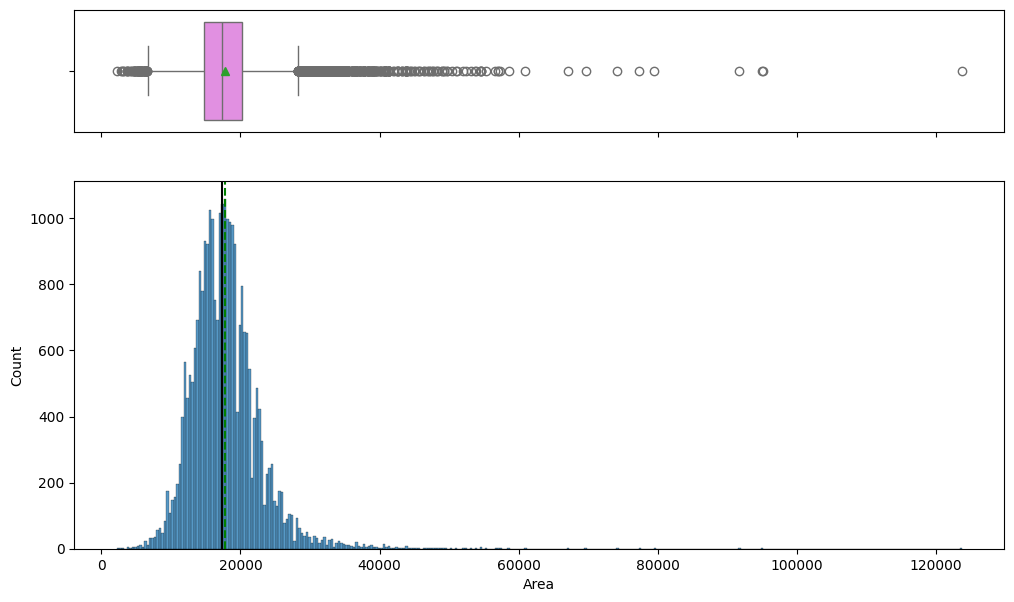

In [ ]:
histogram_boxplot(dimensions_df,'Area')

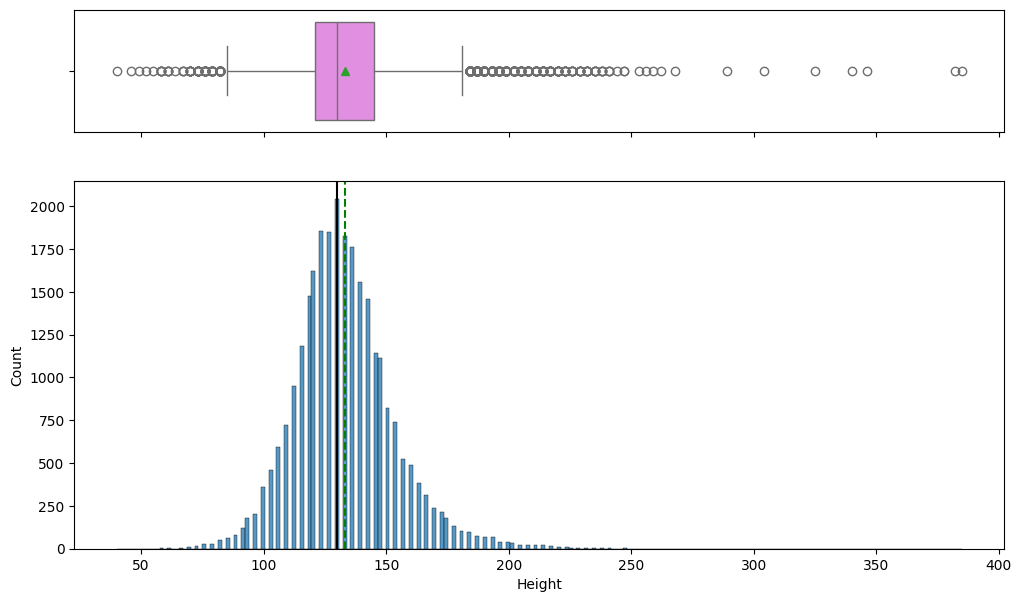

In [ ]:
histogram_boxplot(dimensions_df,'Height')

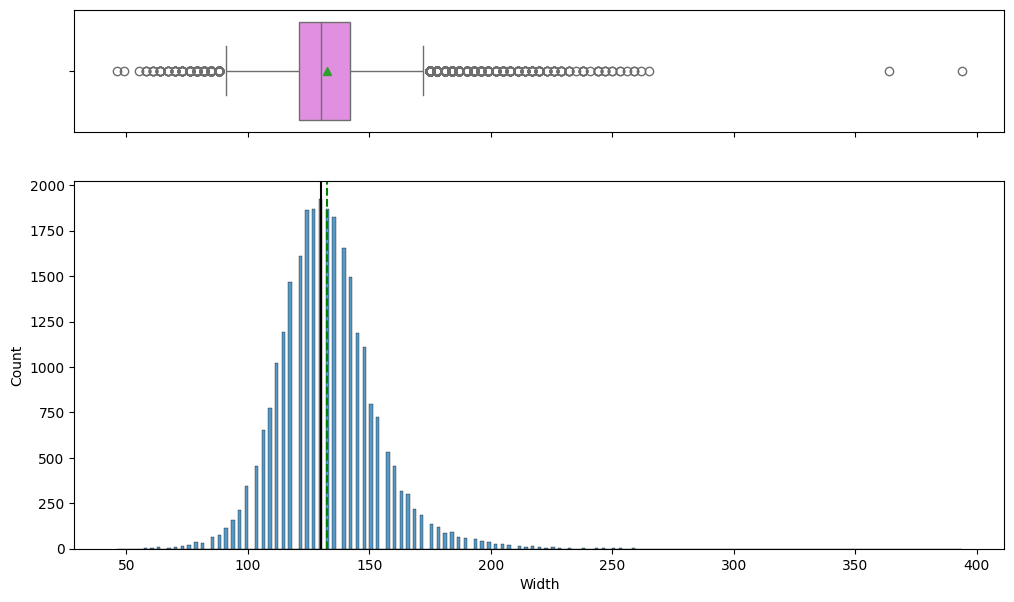

In [ ]:
histogram_boxplot(dimensions_df,'Width')

In [ ]:
dimensions_df.describe()

,Height,Width,Area
count,27475.000000,27475.000000,27475.000000
mean,133.018999,132.509845,17843.173576
std,20.612919,20.014285,4967.768657
min,40.000000,46.000000,2200.000000
25%,121.000000,121.000000,14758.000000
50%,130.000000,130.000000,17290.000000
75%,145.000000,142.000000,20155.000000
max,385.000000,394.000000,123760.000000


In [ ]:
dimensions_df = pd.DataFrame(dimensions_df)

# How many samples have a dimension greater than the mean + 2* sd?
height_high = dimensions_df[dimensions_df["Height"] > 173].count()
width_high = dimensions_df[dimensions_df["Width"] > 173].count()
high = (height_high + width_high)

print(f"The number of samples with a dimension > mean + 2*std : {high}.\n\nThis is {high/(dimensions_df.count())}")

 **Observations**

The distribution of dimensions were normal.The mean ± std for both h and w were 133 ± 20.
If the uniform size were set to 133 ± 2*std --> 173 pixels, only 7% of the samples would need to be downsized.

With the final 224x224 size, there would still be few samples that would have to be downsized.

###<b> Determine final image dimensions

In [ ]:
# make an array where ALL images share their longest dimension size
# where height_max and width_max are the pixel lengths of the final desired sized image
# all images are resized

def image_size_uniform(images, height_max, width_max):
  images_resized = []
  for img in images:
    h, w = img.shape[:2]
    longest = max(h, w)
    scaling_factor = height_max / (max(h, w))

    resized_img = cv2.resize(img, None, fx=scaling_factor, fy = scaling_factor)
    images_resized.append(resized_img)

  return np.array(images_resized)

In [ ]:
# Make all images the same size using padding to fill out empty space
def image_pad_equal_size(images_resized,height_max, width_max):
  images_padded = []
  for img in images_resized:
    h, w = img.shape[:2]

    diff_vert = height_max - h
    pad_top = diff_vert // 2
    pad_bottom = diff_vert - pad_top
    diff_hori = width_max-w
    pad_left = diff_hori // 2
    pad_right = diff_hori - pad_left

    img_padded = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
    assert img_padded.shape[:2] == (height_max, width_max)

    images_padded.append(img_padded)

  return np.array(images_padded)

In [ ]:
# All images resized to share longest length
images_less_than_max=image_size_uniform(X_test, 224, 224)
X_test_padded = image_pad_equal_size(images_less_than_max,224, 224)

images_less_than_max=image_size_uniform(X_train, 224, 224)
X_train_padded = image_pad_equal_size(images_less_than_max,224, 224)

In [ ]:
# Save resized image arrays as npy files.

save('/parent_dir/X_test_padded.npy', X_test_padded)
save('/parent_dir/X_train_padded.npy', X_train_padded)

### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
# OpenCV BGR

# note: the original image arrays are used to avoid counting the added padding
print(f"The range of pixel values:\nX_train_padded:\t ({np.amin(X_train_padded[3])}, {np.amax(X_train_padded[3])})")
print(f"X_test: \t ({np.amin(X_test[3])}, {np.amax(X_test[3])})")

print(f"\n(min, max, mean) of color channels:")
print(f"X_test (Blue):\t{X_test[3][:, :, 0].min()}, {X_test[3][:, :, 0].max()}, {int(X_test[3][:, :, 0].mean())}")
print(f"X_test (Green):\t{X_test[3][:, :, 1].min()}, {X_test[3][:, :, 1].max()}, {int(X_test[3][:, :, 1].mean())}")
print(f"X_test (Red):\t{X_test[3][:, :, 2].min()}, {X_test[3][:, :, 2].max()}, {int(X_test[3][:, :, 2].mean())}")
print(f"\nX_train_padded (Blue):\t{X_train_padded[3][:, :, 0].min()}, {X_train_padded[3][:, :, 0].max()}, {int(X_train_padded[3][:, :, 0].mean())}")
print(f"X_train_padded (Green):\t{X_train_padded[3][:, :, 1].min()}, {X_train_padded[3][:, :, 1].max()}, {int(X_train_padded[3][:, :, 1].mean())}")
print(f"X_train_padded (Red):\t{X_train_padded[3][:, :, 2].min()}, {X_train_padded[3][:, :, 2].max()}, {int(X_train_padded[3][:, :, 2].mean())}")

The range of pixel values:
X_train_padded:	 (0, 226)
X_test: 	 (0.0, 0.7921568751335144)

(min, max, mean) of color channels:
X_test (Blue):	0.0, 0.7921568751335144, 0
X_test (Green):	0.0, 0.7921568751335144, 0
X_test (Red):	0.0, 0.7921568751335144, 0

X_train_padded (Blue):	0, 176, 95
X_train_padded (Green):	0, 184, 98
X_train_padded (Red):	0, 226, 125


####**Observations and insights:**
There should be very good contrast between the components of the cell in both train and testing data sets.

The training set images have slightly lower max intensity in the B and G channels. Otherwise, the 3 channels show similar intensities<br>
In the training set the red channel is higher than the other 2 channels. May be a consequence of the amount of red stained plasmodium found in the RBCs, although why we don't see something similar in the test set is unclear. <br>
It is expected that if the samples were divided into the infected and non-infected samples, the red channel would be more intense in the infected sample set.

###<b> Count the number of values in both uninfected and parasitized

In [ ]:
y_test_df = pd.DataFrame(y_test)
y_train_df = pd.DataFrame(y_train)

print(f"The breakdown of test sample types:\n{y_test_df[0].value_counts()}")
print(f"\nThe breakdown of train sample types:\n{y_train_df[0].value_counts()}")

The breakdown of test sample types:
uninfected     1300
parasitized    1217
Name: 0, dtype: int64

The breakdown of train sample types:
parasitized    12582
uninfected     12376
Name: 0, dtype: int64


###<b>Normalize the images

In [ ]:
X_test_padded_norm = (X_test_padded/255).astype('float32')
X_train_padded_norm = (X_train_padded/255).astype('float32')

In [ ]:
X_train_padded_norm.shape

(24958, 224, 224, 3)

In [ ]:
# Save resized image arrays as npy files.

from numpy import save
save('/parent_dir/X_test_padded_large_shrunk.npy', X_test_padded_large_shrunk)
save('/parent_dir/X_train_padded_norm.npy', X_train_padded_norm)

####<b> Observations and insights:



###<b> Plot to check if the data is balanced

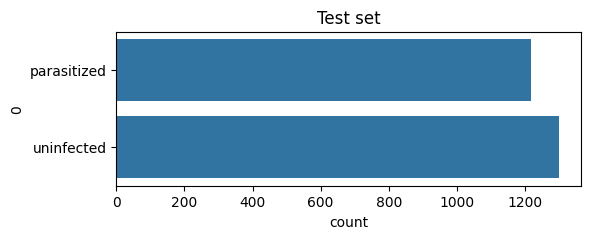

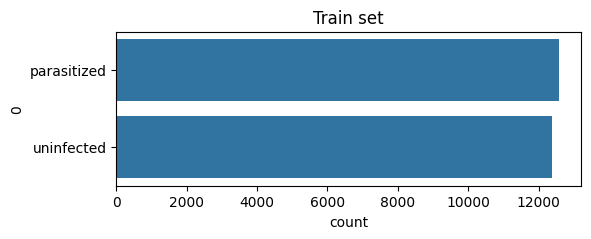

In [ ]:
figure = plt.figure(figsize = (6,2))
sns.countplot(data=y_test_df[0])
plt.title("Test set")
plt.show()
figure = plt.figure(figsize = (6,2))
sns.countplot(data=y_train_df[0])
plt.title("Train set")
plt.show()

####**Observations and insights:**
The training and testing data sets both have sample groups that are close to 1:1 uninfected:infected. They are nicely balanced.

### <b>Data Exploration</b>
Let's visualize the images from the train data

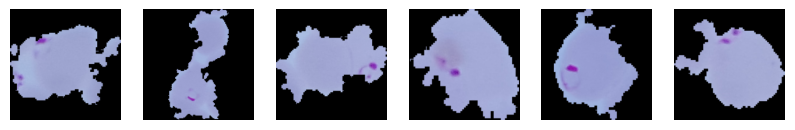

In [ ]:
# First 6 images from the train set (all infected)
figure = plt.figure(figsize=(10, 20))
for i in range(6):
  ax = plt.subplot(1, 6, i + 1)
  ax.axis('off')
  plt.imshow(X_train_padded_norm [i])

plt.show()


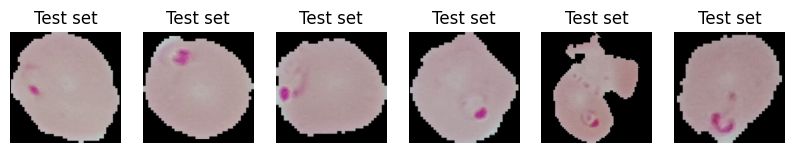

In [ ]:
# First 6 samples of the test set (all infected)

figure = plt.figure(figsize=(10, 20))
for i in range(6):
  ax = plt.subplot(1, 6, i + 1)
  ax.axis('off')
  plt.title("Test set")
  plt.imshow(X_test_padded_norm [i])

plt.show()

####**Observations and insights:**
Unexpectedly, the brightness and the general color palette is cooler in the training set despite these samples all being infected.<br>
There is no obvious trend as to there being a consistant shape.
It would be interesting to see the entire data set to see if these differences are across the entire set. If so, it is concerning as some color features may be misleading. Hopefully, the learning will focus on the contrast of the stain and cytoplasm. (If so, it would allow for grey scale images to be used. More practical if the images have to be transmitted via phone).

###**Visualize more images**<br>
How extensive are the color differences?

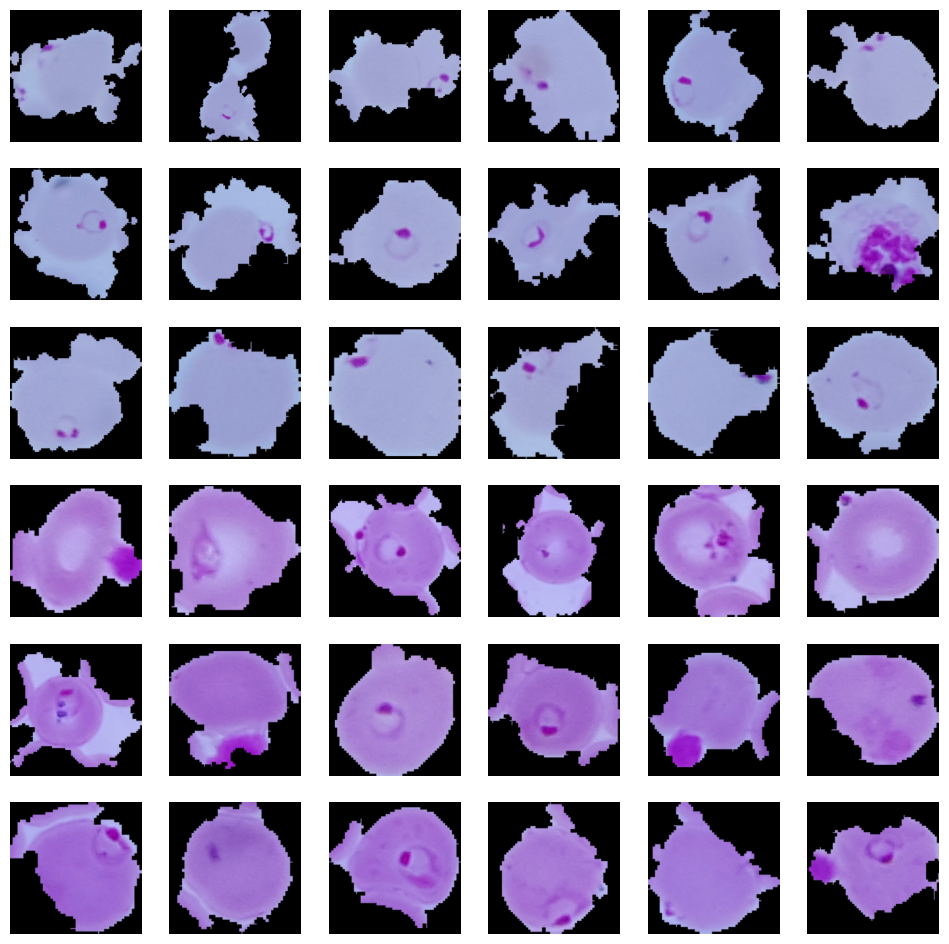

In [ ]:
fig = plt.figure(figsize = (12, 12))

for i in range(36):
  ax = plt.subplot(6, 6, i + 1)
  ax.axis('off')
  plt.imshow(X_train_padded_norm [i])

plt.show()

####**Observations and insights:**
Continuing from the observations of the previous plots, there is great variation in color saturation. The more saturated images show the expected RBC donut-like morphology.<br>
One wonders if the blebbing and generally poor condition of the cells are due to sample handling resulting in cell lysis, or if there is something to be learned by modeling.

###<b> Plotting the mean images for parasitized and uninfected

In [ ]:
# Split images by infection status only

parasitized_images = []
uninfected_images = []

for i, j in zip(X_test_padded_norm, y_test):
  if j=='parasitized':
    parasitized_images.append(i)
  else:
    uninfected_images.append(i)

# continue adding to the lists from the training samples
len(uninfected_images)
for i, j in zip(X_train_padded_norm, y_train):
  if j=='parasitized':
    parasitized_images.append(i)
  else:
    uninfected_images.append(i)

print(len(parasitized_images))

13799


In [ ]:
# convert to np arrays
uninfected_avg = np.array(uninfected_images)
parasitized_avg = np.asarray(parasitized_images)
print(uninfected_avg.shape, parasitized_avg.shape)

(13676, 224, 224, 3) (13799, 224, 224, 3)


<b> Mean image for parasitized

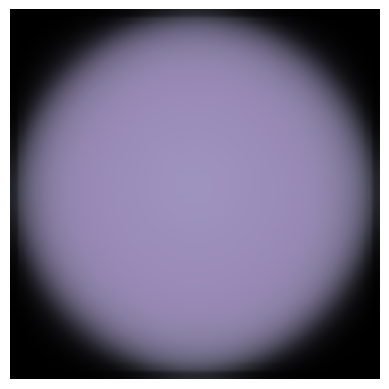

In [ ]:
parasitized_avg = np.mean(parasitized_images, axis=0)

parasitized_avg=plt.imshow(parasitized_avg)
plt.axis('off')

plt.show()

<b> Mean image for uninfected

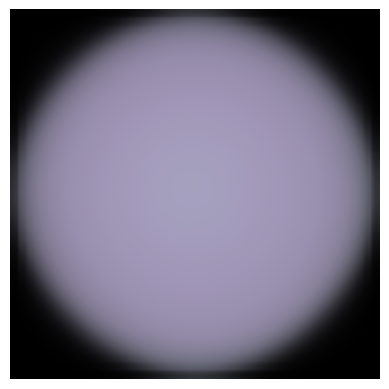

In [ ]:
uninfected_avg = np.mean(uninfected_images, axis=0)

uninfected_avg =plt.imshow(uninfected_avg)
plt.axis('off')

plt.show()

####**Observations and insights:**
There is very little structure that could be overlaid to get a better signal separation between the stained parasite and the RBC, which explains the averaged round shape.

By eye, the infected cell appears redder consistent with the little blobs of red-stained parasite in different places within the RBCs.

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [ ]:
# Since we originally opened our images using OpenCV, the channels are in the order: BGR
X_train_hsv = []

for img in X_train_padded_norm:
  img = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2HSV)
  X_train_hsv.append(img)

X_train_hsv=np.array(X_train_hsv)

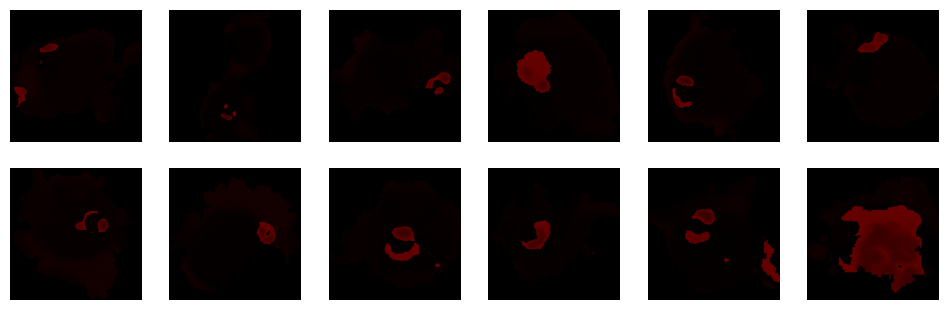

In [ ]:
# Visualize the HSV converted Train data, samples 1-12

fig = plt.figure(figsize = (12, 12))
#fig.set_size_inches(16,16)

for i in range(12):
  ax = plt.subplot(6, 6, i + 1)
  ax.axis('off')
  img=X_train_hsv[i]
  plt.imshow(img.astype('uint8'))
plt.show();

###<b> Converting the test data

In [ ]:
X_test_hsv = []

for img in X_test_padded_norm:
  img = cv2.cvtColor(img[:, :, :3], cv2.COLOR_RGB2HSV)
  X_test_hsv.append(img)

X_test_hsv=np.array(X_test_hsv)

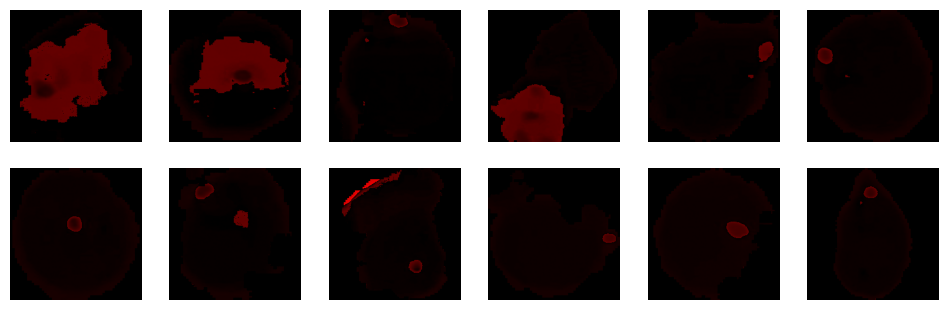

In [ ]:
# Visualize the HSV converted Test data, samples 1-12

fig = plt.figure(figsize = (12, 12))
#fig.set_size_inches(16,16)

for i in range(12):
  ax = plt.subplot(6, 6, i + 1)
  ax.axis('off')
  img=X_test_hsv[100:][i]
  plt.imshow(img.astype('uint8'))
plt.show();


In [ ]:
# Save hsv image arrays as npy files.

save('/content/drive/MyDrive/ADSP_Course_1/Capstone Project/X_test_hsv.npy', X_test_hsv)
save('/content/drive/MyDrive/ADSP_Course_1/Capstone Project/X_train_hsv.npy', X_train_hsv)

In [ ]:
X_test_hsv.shape, X_train_hsv.shape

((2517, 224, 224, 3), (24958, 224, 224, 3))

####**Observations and insights:**

Again there is great color intensity differences between samples. Changing the color map makes it harder to see the parasite. However, the human eye and the digitized information aren't always in agreement. It is worth comparing the with the original in a DL model.

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [ ]:
# Blurring

gbx=[]  ## to hold the blurred images
for i in np.arange(0,100,1):
    b= cv2.GaussianBlur(X_train_padded_norm[i], (5, 5), 0)
    gbx.append(b)
gbx=np.array(gbx)

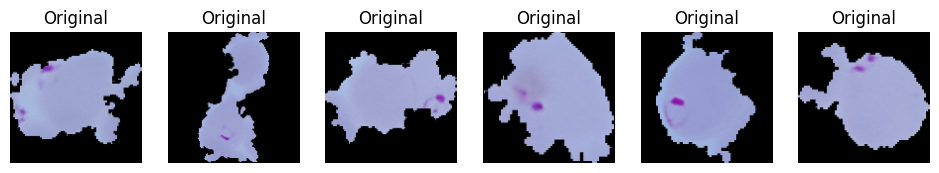

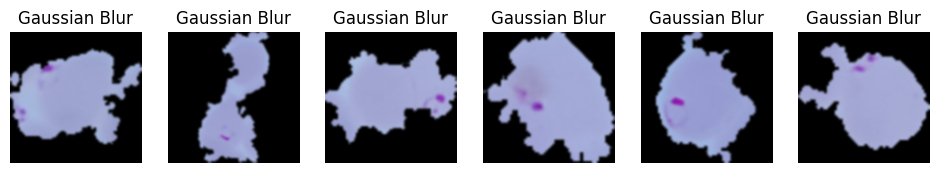

(100, 133, 133, 3)


In [ ]:
# Visualizing the blur

# Original images
figure = plt.figure(figsize=(20,60))
for i in range(6):
  ax = plt.subplot(1, 10, i + 1)
  ax.axis('off')
  plt.imshow(X_train_padded_norm[i])
  plt.title("Original")
plt.show()

# Blurred images
figure = plt.figure(figsize=(20,60))
for i in range(6):
  ax = plt.subplot(1, 10, i + 1)
  ax.axis('off')
  plt.imshow(gbx[i])
  plt.title("Gaussian Blur")
plt.show()

print(gbx.shape)

###<b> Gaussian Blurring on test data

In [ ]:
# Blur the test set samples

test_gauss=[]  ## to hold the blurred images
for i in np.arange(0,100,1):
    b= cv2.GaussianBlur(X_test_padded_norm[i], (5, 5), 0)
    test_gauss.append(b)
test_gauss=np.array(test_gauss)

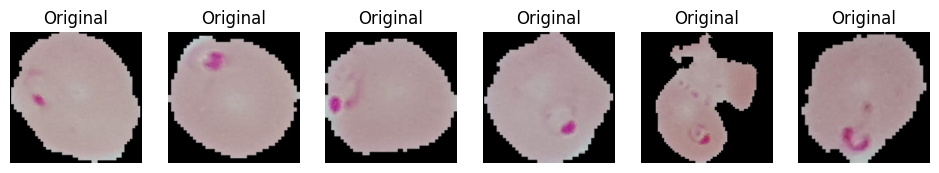

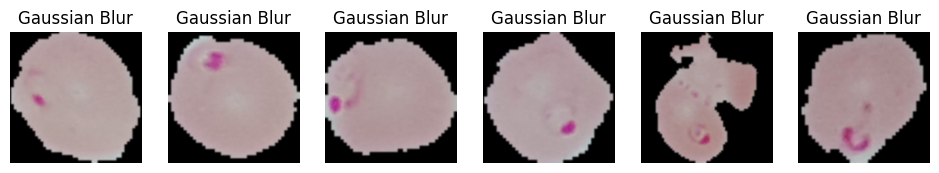

In [ ]:
# Original samples
figure = plt.figure(figsize=(20,60))
for i in range(6):
  ax = plt.subplot(1, 10, i + 1)
  ax.axis('off')
  plt.imshow(X_test_padded_norm[i])
  plt.title("Original")
plt.show()

# Blurred samples
figure = plt.figure(figsize=(20,60))
for i in range(6):
  ax = plt.subplot(1, 10, i + 1)
  ax.axis('off')
  plt.imshow(test_gauss[i])
  plt.title("Gaussian Blur")
plt.show()

####**Observations and insights:**

Gaussian blurring would not be useful in this case. It is useful for images taken in low light (not so w/ microscopic images in general), it can eliminate bright pixels, which would also reduce contrast (not helpful in this case), and for reducing noise from blurry images (shouldn't be the case with the raw data, but processing the data may introduce blurring).

In this case, there is little difference between the original images (top row) and the blurred images (bottom row).

## **Model Building**

### **Base Model**

**Note:** The Base Model was fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a simple ANN architecture as compared to CNN models.<br>

###<b> Importing the required libraries for building and training our Model

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
import random
import keras
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, LeakyReLU
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

####<B>One Hot Encoding the train and test labels

In [ ]:
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

#OHE
y_train_ohe = pd.get_dummies(y_train)
y_test_ohe = pd.get_dummies(y_test)

#Label encoding to change the strings to integers.
y_train_num = y_train_df.apply(LabelEncoder().fit_transform)
y_test_num = y_test_df.apply(LabelEncoder().fit_transform)

In [ ]:
y_train_ohe.shape, y_train_num.shape, X_train_padded_norm.shape

((24958, 2), (24958, 1), (24958, 224, 224, 3))

###<b> Building the model

A simple ANN with a few dense layers was used as a starting point.

In [ ]:
backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
model=Sequential()

# Add input layer
model.add(Flatten(input_shape = (224, 224, 3)))

# Add hidden layers
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))

# Output layer
model.add(Dense(2, activation = 'softmax'))

###<b> Compiling the model

In [ ]:
# compile the model
model.compile(optimizer=Adam(learning_rate = 0.001), loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 64)                9633856   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 9636498 (36.76 MB)
Trainable params: 9636498 (36.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<b> Fit and train our Model

In [ ]:
history = model.fit(X_train_padded_norm, y_train_ohe, validation_split = 0.2, batch_size = 32, epochs = 10, verbose = 1)

###<b> Evaluating the model on test data

In [ ]:
y_pred_test=model.predict(X_test_padded_norm)

79/79 [==============================] - 1s 6ms/step


<b>Plotting the train and validation curves

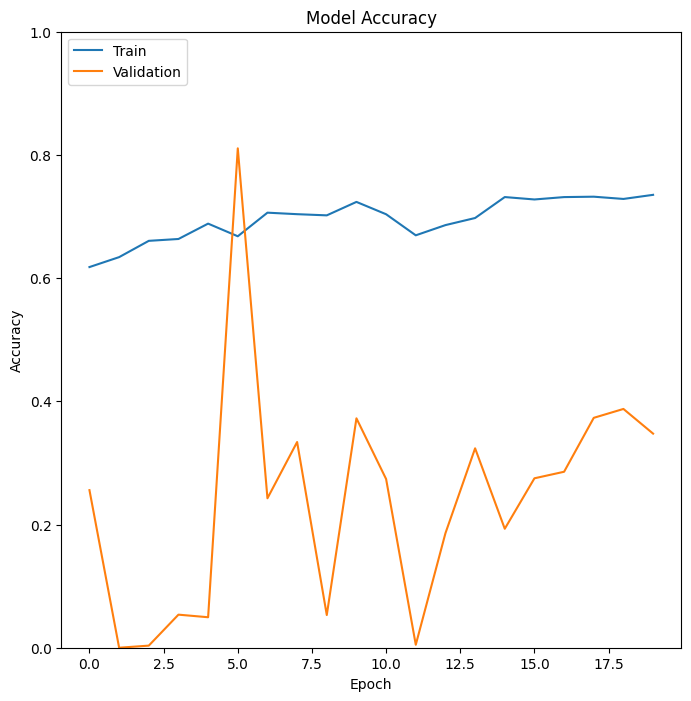

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

<b> Plotting the confusion matrix

In [ ]:
# reverse the one hot coding & calculate max probability
y_pred_classes = np.argmax(y_pred_test, axis = 1)
y_pred_max_prob = np.max(y_pred_test, axis = 1)

# Confirming the extra dimension added by the OHE has been removed
print(type(y_pred_classes[0]))
print(type(y_pred_max_prob[0]))
print(type(y_test_num[0]))

# print classification report
print(classification_report(y_test_num, y_pred_classes))

<class 'numpy.int64'>
<class 'numpy.float32'>
<class 'pandas.core.series.Series'>
              precision    recall  f1-score   support

           0       0.56      0.82      0.66      1217
           1       0.70      0.40      0.51      1300

    accuracy                           0.60      2517
   macro avg       0.63      0.61      0.58      2517
weighted avg       0.63      0.60      0.58      2517



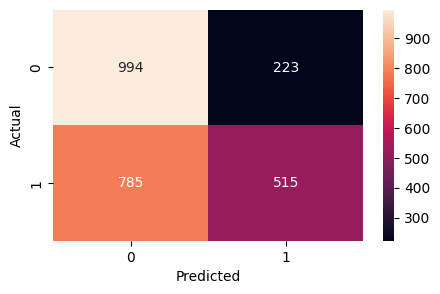

In [ ]:
# Confusion matrix
cm=confusion_matrix(y_test_num, y_pred_classes)
y_classes = range(0,2)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot = True, fmt = '.0f', xticklabels = y_classes, yticklabels=y_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted');

##**Summary:**<br>
This was a poor model where the training set was certainly overfit compared to the validation set,
Looking at the confusion matrix, ~40% of the test set was misclassified.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding convolution layers


In [ ]:
backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

###<b> Building the Model

In [ ]:
model_1=Sequential()

# Add hidden layers
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation = 'relu', padding='same', data_format='channels_last',input_shape = (224, 224, 3)))
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation = 'relu', padding='same', data_format='channels_last'))
model_1.add(MaxPool2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dense(32, activation = 'relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(16, activation = 'relu'))

# Output layer
model_1.add(Dense(2, activation = 'sigmoid'))

###<b> Compiling the model

In [ ]:
# compile the model
model_1.compile(optimizer=Adam(learning_rate = 0.001), loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model_1.summary()
print(y_train_ohe.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                12845120  
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

<b>Fit and Train the model

In [ ]:
history_1 = model_1.fit(X_train_padded_norm, y_train_ohe, validation_split = 0.2, batch_size = 128, epochs = 12, verbose = 1)

###<b> Evaluating the model

In [ ]:
y_pred_test=model_1.predict(X_test_padded_norm)

79/79 [==============================] - 1s 9ms/step


<b> Plotting the confusion matrix

In [ ]:
# reverse the one hot coding & calculate max probability
y_pred_classes = np.argmax(y_pred_test, axis = 1)
y_pred_max_prob = np.max(y_pred_test, axis = 1)

# Confirming the extra dimension added by the OHE has been removed
print(type(y_pred_classes[0]))
print(type(y_pred_max_prob[0]))
print(type(y_test_num[0]))


# print classification report
print(classification_report(y_test_num, y_pred_classes))

<class 'numpy.int64'>
<class 'numpy.float32'>
<class 'pandas.core.series.Series'>
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1217
           1       0.94      0.89      0.92      1300

    accuracy                           0.92      2517
   macro avg       0.92      0.92      0.92      2517
weighted avg       0.92      0.92      0.92      2517



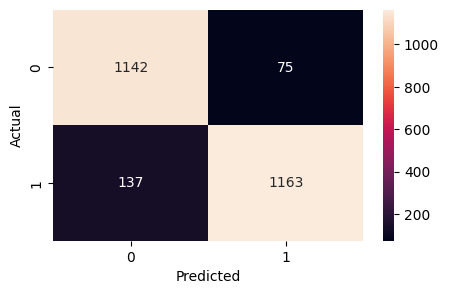

In [ ]:
# Confusion matrix
cm=confusion_matrix(y_test_num, y_pred_classes)
y_classes = range(0,2)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot = True, fmt = '.0f', xticklabels = y_classes, yticklabels=y_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted');

<b> Plotting the train and the validation curves

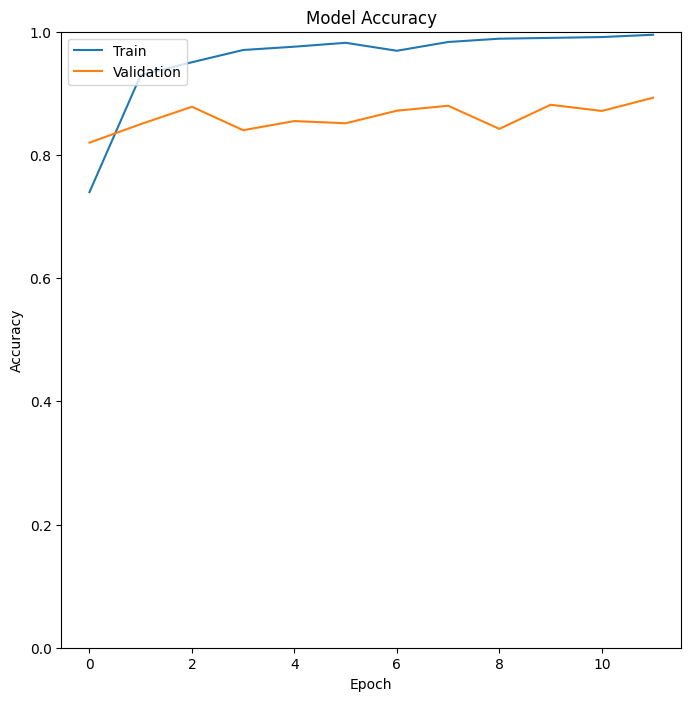

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

##**Observations:**

Pretty good fit overall, but the training set was definitely overfit.<br>
Addition of the convolution layers was key.

BatchNormalization and dropout layers should be helpful. Leaky Relu will also be tried.

###<b> Model 2 with Batch Normalization

In [ ]:
backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

###<b> Building the Model

In [ ]:
model_2=Sequential()

# Add hidden layers
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', data_format='channels_last',input_shape = (224, 224, 3)))
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', data_format='channels_last'))
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(MaxPool2D(pool_size=(2, 2)))
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(64))
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(Dense(16))
model_2.add(LeakyReLU(alpha=0.1))
# Output layer
model_2.add(Dense(2, activation = 'sigmoid'))

###<b>Compiling the model

In [ ]:
# compile the model
model_2.compile(optimizer=Adam(learning_rate = 0.001), loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model_2.summary()
print(y_train_ohe.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 16)      64        
 Normalization)                                         

<b> Using callbacks

In [ ]:
callback = EarlyStopping(monitor='loss', patience = 3)

<b>Fit and train the model

In [ ]:
history_2 = model_2.fit(X_train_padded_norm, y_train_ohe, validation_split = 0.2, batch_size = 128, epochs = 16, verbose = 1, callbacks=callback)

<b>Plotting the train and validation accuracy

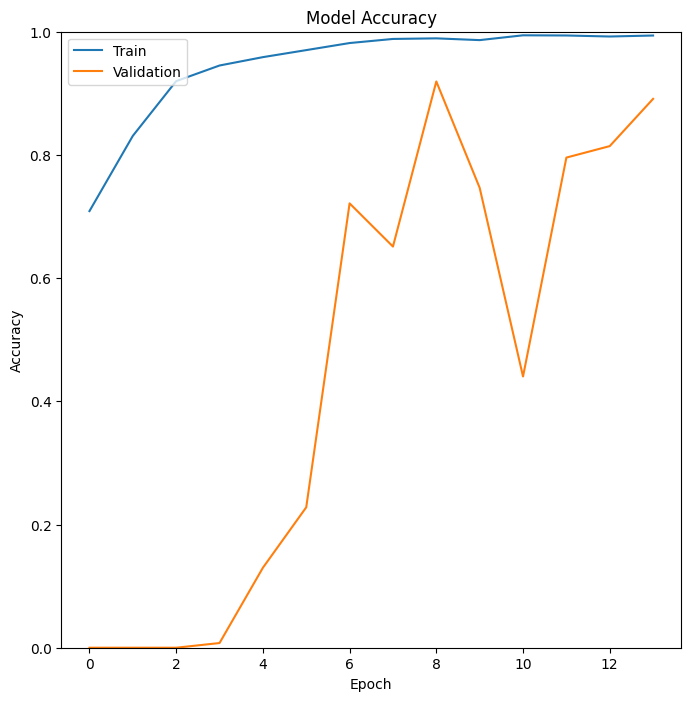

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

###<b>Evaluating the model

In [ ]:
y_pred_test=model_2.predict(X_test_padded_norm)

79/79 [==============================] - 1s 9ms/step


<b> Generate the classification report and confusion matrix

In [ ]:
# reverse the one hot coding & calculate max probability
y_pred_classes = np.argmax(y_pred_test, axis = 1)
y_pred_max_prob = np.max(y_pred_test, axis = 1)

# Confirming the extra dimension added by the OHE has been removed
print(type(y_pred_classes[0]))
print(type(y_pred_max_prob[0]))
print(type(y_test_num[0]))


# print classification report
print(classification_report(y_test_num, y_pred_classes))

<class 'numpy.int64'>
<class 'numpy.float32'>
<class 'pandas.core.series.Series'>
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1217
           1       0.88      0.91      0.90      1300

    accuracy                           0.89      2517
   macro avg       0.89      0.89      0.89      2517
weighted avg       0.89      0.89      0.89      2517



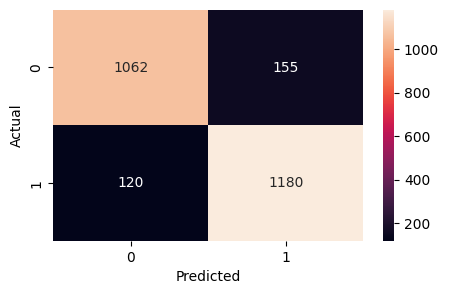

In [ ]:
# Confusion matrix
cm=confusion_matrix(y_test_num, y_pred_classes)
y_classes = range(0,2)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot = True, fmt = '.0f', xticklabels = y_classes, yticklabels=y_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted');

###**Observations and insights:**

Neither the Leaky Relu nor the Batch Normalization sufficiently reduced the overfitting of the training set.

The performance against the test set was worse.

###**Model 3 with Data Augmentation**<br>
Data augmentation was the assigned task, however, as seen below, it is not a worthwhile endeavor. Efforts to reduce overtraining were tried instead.

In [ ]:
backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
train_datagen = ImageDataGenerator(shear_range=(0.0-0.5))
result_data= train_datagen.flow(X_train_padded_norm[0:5], y_train[0:5], batch_size=128)

####<B>Visualizing Augmented images

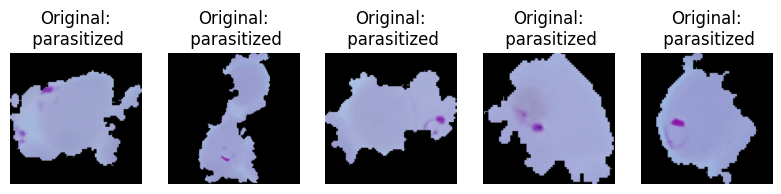

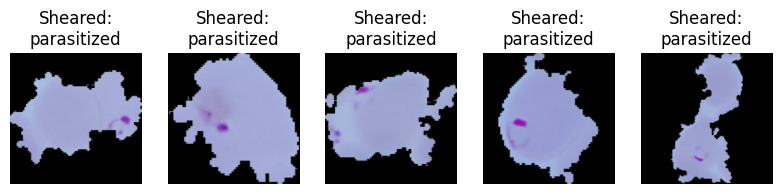

In [ ]:
figure = plt.figure(figsize=(20,60))
for i in range(5):
  ax = plt.subplot(1, 10, i + 1)
  ax.axis('off')
  plt.imshow(X_train_padded_norm[i])
  plt.title("Original:\n parasitized")
plt.show()

figure = plt.figure(figsize=(20,60))

x = result_data.next()
a=x[0]
b=x[1]
for i in range(0, 5):
  ax = plt.subplot(1, 10, i + 1)
  ax.axis('off')
  plt.imshow(a[i])
  plt.title(f"Sheared:\n{b[i]}")
plt.show()

###**Observations and insights:**

Of the different augmentations, there are few that would be of use with irregular, round-ish shapes (RBC). The stained parasite itself may have a little more shape (like a worm), but even that isn't a hard and fast rule. No rotation or flips would be even noticable.<br>
The only possible assistance could come from trying different brightness or channel_shifts. (I did try them, but I got black images, so I used shear for the example images above). Shear is a good example of how deformation of any sort just doesn't create a noticable change.<br>
Due to this lack of impact, data augmentation will not be used in this next model.

###<b>Building the Model

In [ ]:
model_3=Sequential()

# Add hidden layers
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation = 'relu', data_format='channels_last',input_shape = (224, 224, 3)))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation = 'relu',data_format='channels_last'))
model_3.add(MaxPool2D(pool_size=(2, 2)))
model_3.add(BatchNormalization())
model_3.add(Flatten())
model_3.add(Dense(64, activation = 'relu'))
model_3.add(Dropout(0.25))
model_3.add(BatchNormalization())
model_3.add(Dense(32, activation = 'relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(16, activation = 'relu'))
model_3.add(Dropout(0.25))
# Output layer
model_3.add(Dense(2, activation = 'sigmoid'))

<b>Using Callbacks

In [ ]:
callback = EarlyStopping(monitor='loss', patience = 3)

<b> Fit and Train the model

In [ ]:
# compile the model
model_3.compile(optimizer=Adam(learning_rate = 0.001), loss= 'categorical_crossentropy', metrics = ['accuracy'])

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 16)      64        
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [ ]:
history_3 = model_3.fit(X_train_padded_norm, y_train_ohe, validation_split = 0.2, batch_size = 128, epochs = 20, verbose = 1, callbacks=callback)

Epoch 1/20
156/156 [==============================] - 17s 85ms/step - loss: 0.6403 - accuracy: 0.6501 - val_loss: 0.9088 - val_accuracy: 4.0064e-04
Epoch 2/20
156/156 [==============================] - 8s 51ms/step - loss: 0.5712 - accuracy: 0.7114 - val_loss: 1.0678 - val_accuracy: 0.0000e+00
Epoch 3/20
156/156 [==============================] - 8s 51ms/step - loss: 0.4293 - accuracy: 0.8178 - val_loss: 2.6045 - val_accuracy: 0.0000e+00
Epoch 4/20
156/156 [==============================] - 8s 51ms/step - loss: 0.3162 - accuracy: 0.8760 - val_loss: 0.4127 - val_accuracy: 0.9537
Epoch 5/20
156/156 [==============================] - 8s 51ms/step - loss: 0.2420 - accuracy: 0.9142 - val_loss: 0.5906 - val_accuracy: 0.9117
Epoch 6/20
156/156 [==============================] - 8s 50ms/step - loss: 0.2182 - accuracy: 0.9228 - val_loss: 0.3339 - val_accuracy: 0.9613
Epoch 7/20
156/156 [==============================] - 8s 50ms/step - loss: 0.1958 - accuracy: 0.9312 - val_loss: 0.3698 - val_acc

###<B>Evaluating the model

<b>Plot the train and validation accuracy

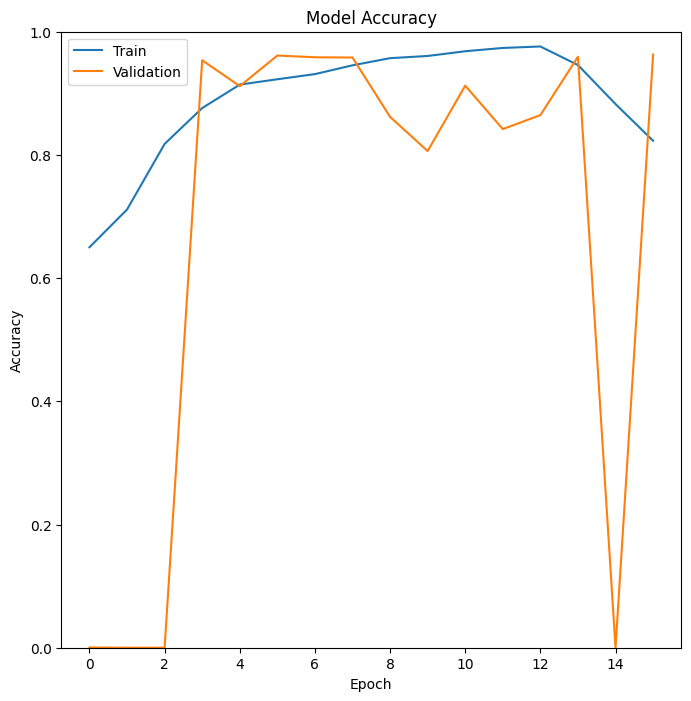

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

<B>Plotting the classification report and confusion matrix

In [ ]:
y_pred_test=model_3.predict(X_test_padded_norm)

79/79 [==============================] - 1s 9ms/step


In [ ]:
# reverse the one hot coding & calculate max probability
y_pred_classes = np.argmax(y_pred_test, axis = 1)
y_pred_max_prob = np.max(y_pred_test, axis = 1)

# Confirming the extra dimension added by the OHE has been removed
print(type(y_pred_classes[0]))
print(type(y_pred_max_prob[0]))
print(type(y_test_num[0]))


# print classification report
print(classification_report(y_test_num, y_pred_classes))

<class 'numpy.int64'>
<class 'numpy.float32'>
<class 'pandas.core.series.Series'>
              precision    recall  f1-score   support

           0       0.77      0.19      0.31      1217
           1       0.56      0.95      0.70      1300

    accuracy                           0.58      2517
   macro avg       0.67      0.57      0.51      2517
weighted avg       0.66      0.58      0.51      2517



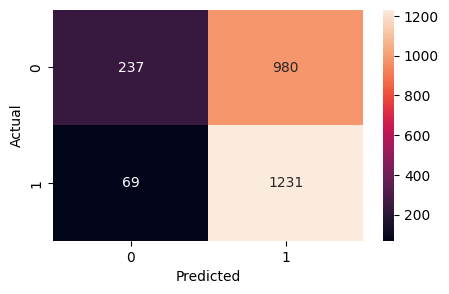

In [ ]:
# Confusion matrix
cm=confusion_matrix(y_test_num, y_pred_classes)
y_classes = range(0,2)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot = True, fmt = '.0f', xticklabels = y_classes, yticklabels=y_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted');

### **Pre-trained model (VGG16)**


In [ ]:
backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
model = VGG16(weights = 'imagenet')
model.summary

553467096/553467096 [==============================] - 3s 0us/step


<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x7bbf55cf5930>>

In [ ]:
transfer_layer = model.get_layer('block5_pool')
vgg_model=VGG16(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

# freeze VGG16 layers
for layer in vgg_model.layers:
  layer.trainable = False

for layer in vgg_model.layers:
  print(layer, layer.trainable)

58889256/58889256 [==============================] - 1s 0us/step
<keras.src.engine.input_layer.InputLayer object at 0x7bbf78155b70> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7bbf55cd2d70> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7bbf54ae3d00> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7bbf55cd3880> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7bbf551067d0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7bbf550b5960> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7bbf55cd0250> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7bbf55cf5000> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7bbf55cd3e20> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7bbf55105fc0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7bbf55cd02e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7bb

In [ ]:
model_4 = Sequential()
model_4.add(vgg_model)
model_4.add(Flatten())
model_4.add(Dense(64, activation = 'relu'))
model_4.add(Flatten())
model_4.add(Dense(32, activation = 'relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(16, activation = 'relu'))

# Output layer
model_4.add(Dense(2, activation = 'sigmoid'))

###<b>Compiling the model

In [ ]:
# compile the model
model_4.compile(optimizer=Adam(learning_rate = 0.001), loss= 'categorical_crossentropy', metrics = ['accuracy'])

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                5

<b> using callbacks

In [ ]:
callback = EarlyStopping(monitor='loss', patience = 3)

<b>Fit and Train the model

In [ ]:
history_4 = model_4.fit(X_train_padded_norm, y_train_ohe, validation_split = 0.2, batch_size = 128, epochs = 16, verbose = 1, callbacks=callback)

Epoch 1/16
156/156 [==============================] - 29s 153ms/step - loss: 0.4112 - accuracy: 0.8061 - val_loss: 0.7881 - val_accuracy: 0.7216
Epoch 2/16
156/156 [==============================] - 17s 112ms/step - loss: 0.1961 - accuracy: 0.9247 - val_loss: 0.4811 - val_accuracy: 0.8506
Epoch 3/16
156/156 [==============================] - 17s 112ms/step - loss: 0.1700 - accuracy: 0.9345 - val_loss: 0.0566 - val_accuracy: 0.9848
Epoch 4/16
156/156 [==============================] - 18s 113ms/step - loss: 0.1442 - accuracy: 0.9459 - val_loss: 0.1446 - val_accuracy: 0.9629
Epoch 5/16
156/156 [==============================] - 17s 112ms/step - loss: 0.1186 - accuracy: 0.9575 - val_loss: 0.3719 - val_accuracy: 0.8744
Epoch 6/16
156/156 [==============================] - 17s 111ms/step - loss: 0.1119 - accuracy: 0.9594 - val_loss: 0.3248 - val_accuracy: 0.9044
Epoch 7/16
156/156 [==============================] - 17s 111ms/step - loss: 0.0931 - accuracy: 0.9670 - val_loss: 0.1897 - val_ac

<b>Plot the train and validation accuracy

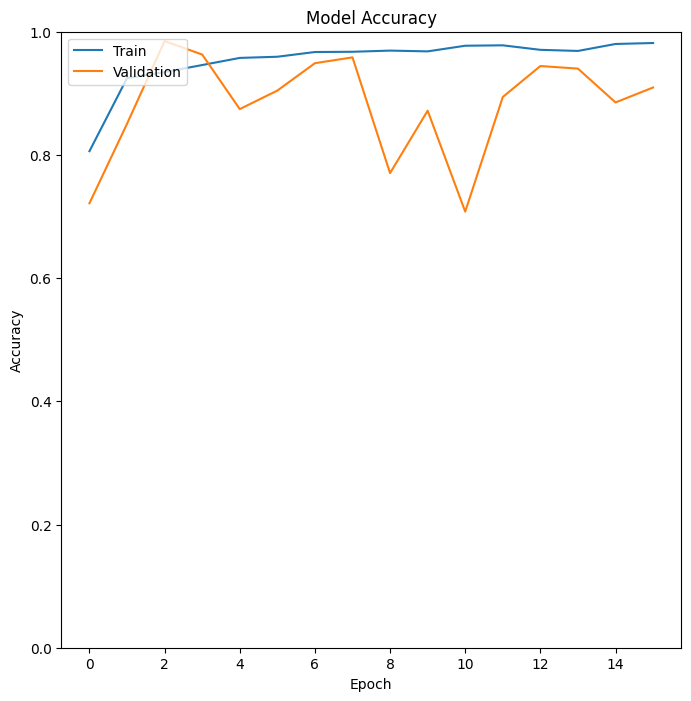

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

###**Observations and insights:**

This is the first model where the validation curve wasn't bouncing around. The overfitting doesn't seem to be a problem.

###<b> Evaluating the model

In [ ]:
y_pred_test=model_4.predict(X_test_padded_norm)

79/79 [==============================] - 4s 33ms/step


<b>Plotting the classification report and confusion matrix

In [ ]:
# reverse the one hot coding & calculate max probability
y_pred_classes = np.argmax(y_pred_test, axis = 1)
y_pred_max_prob = np.max(y_pred_test, axis = 1)

# Confirming the extra dimension added by the OHE has been removed
print(type(y_pred_classes[0]))
print(type(y_pred_max_prob[0]))
print(type(y_test_num[0]))


# print classification report
print(classification_report(y_test_num, y_pred_classes))

<class 'numpy.int64'>
<class 'numpy.float32'>
<class 'pandas.core.series.Series'>
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1217
           1       0.96      0.93      0.94      1300

    accuracy                           0.94      2517
   macro avg       0.94      0.94      0.94      2517
weighted avg       0.94      0.94      0.94      2517



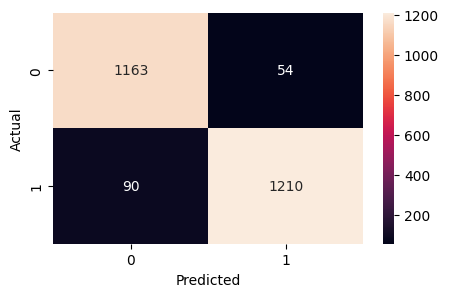

In [ ]:
# Confusion matrix
cm=confusion_matrix(y_test_num, y_pred_classes)
y_classes = range(0,2)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot = True, fmt = '.0f', xticklabels = y_classes, yticklabels=y_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted');

####**Observations and Conclusions drawn from the final model:**

This model performed the best. The recall and the precision were nicely balanced at 0.94.
The learning was complete by the 3rd epoch.

The confusion matrix has given the best result so far.

This transfer model will be saved.



##**Improvements to try:**<br>

**Data-related ideas / concerns:**
- First, I would like to check out the data. What do the samples that were misclassified look like? If they were misclassified to begin with, then those labels would need changing and the stats would look better. Another possible reason for misclassification is if they were classified based on the patient's diagnosis not on the classification of the individual cell.
- Second, again with the data: The training and testing datasets acted so out of sync, that it would be interesting to see how a different train / test split would perform.
- Third, cross validation could be used to try to reduce those differences that *seem* to be there.
- Fourth, different color schema (*e.g.* HSV, data augmentation on the visual aspects).

**Model-related ideas / concerns:**
- The pretrained model done here has some excellent results, although they could be better. Other models may be more relevant and should be tried. YOLO3, YOLO4 have been used by other malaria models for small image detection, so should probably be tried.
- Hyperparameter tuning would be worthwhile.



####**Refined insights**:

**The problem formulation:** (from the top)

1) Are the data of good enough quality to teach a model?
  **YES**
  The data set was large enough and well balanced. The images were of sufficient quality to be used. A higher resolution would have been preferred, but probably not a good use of comp resources.<br>
2) What data processing will be required?
**Not a lot**<br>
  Resizing to uniform dimensions.
  Other data manipulation either didn't appear to do much or worsened the images. The changes to color (e.g. HSV color conversion) were planned to be tested. <br>
3) What image content features are important? The stained plasmodium within the cell? The cell size and shape?<br>
Based on the images visualized throughout, it *appears* that size and shape have little bearing on the infection-state of the RBCs, rather it is the contrast between the the cell and the stained parasite. (It's the quality of the images that suggest that morphology doesn't change upon infection. Ground truth is that some strains do have an effect on size and shape.)<br>
4) How many images per patient are required to minimize any false diagnoses?<br>
- Based on a 6% misclassification rate, I would recommend using more than one sample. This is due not only to the model, but to the sample quality themselves.
- These pictures were of single cells, a single blood smear with multiple cells should be sufficient to properly diagnose infection if the model could be trained to evaluate each cell in the field.


####**Comparison of various techniques and their relative performance**:
How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?<br>
- The initial model with no convolution steps performed poorly. Addition of Conv2D in Model 1 vastly improved performance, although the training set was vastly overfit.
- Model 2 substituted all the ReLU activations for leaky ReLU and added batch normalization. Again, the training set was overfit compared to the validation set. The performance against the testing set was diminished. The Leaky ReLU substitution for all the activation steps and addition of 2 batch normalization layers were not helpful.
- Model 3: Data augmentation was explored outside the model although only the images of sheared data were displayed. It was not implemented in the model as either the utility was low (shape-based augmentations) or all signal was lost with changes to the channels or brightness. That would have to be more thoroughly explored before giving it a try. Instead, dropout layers were added to try to reduce overfitting. The validation set looked a bit better versus the training set, but when evaluated on the test set, the model preferred to predict most samples as infected: many False Positives
- Model 4: This was the transfer model. All the convolution layers from the original VGG16 model were used. This one performed the best. 94% precision and recall of the test set.

####**Proposal for the final solution design**:
The VGG16 pretrained model is the one to move forward with. Although it still misclassifies 6% of the samples, it appears to be the most well-behaved. Overfitting didn't appear to be an issue. The variability of the validation set performance was not as bad as in most of the other models.

There are a number of ways to improve the model both with addressing the input data and tweaks to the model itself (as elucidated above).

## **Final Thoughts**

Although expert microscopists have an accuracy rate of 98%, the transfer model at 94% accuracy would be welcomed by health practitioners that don't have such expertise and would like to start a treatment plan immediately with patients that cannot easily find the time or resources to visit clinics.

The current iteration of the model has some drawbacks, the largest of which is that the dataset was artificially prepared by clipping individual cells out of a larger image. We need to refine the model using images containing many cells. These samples will also have a lot of detritus that will be nonspecifically stained and thus increase false positives that will need to be trained out.

The second thing the model lacks compared to the state-of-the-art human, is the ability to determine the strain of plasmodium that the cells are infected with. This is a critical part of the diagnostic (and thus treatment) process.

The recommendations are not resource intensive:<br>
1) Acquire images that are not cropped and represent both the thick and thin blood smears currently used to diagnose infection and plasmodium strain. There are a number of sample sets freely available to look into.<br>
2) These images should include samples infected with the most common plasmodium strains.<br>
3) Retrain models based on Model 4.

If the results look good, then collaborations with organizations such as the Gates Foundation, WHO, or CDC should be looked into.

There are a number of models that have been published recently that show very good accuracy by all measurements (precision, recall, F1-score). They suffer from different weaknesses, but are further ahead.



